# Initial Loading of data from directories to dataframes along with stratify

We took the data from frieberg datatset and Groceries datatset from kaggle and the woking dataset consisting of fruits and vegetables as unpacked is created by our team with the help of fruits-360 , fruits-16k , vegnet and all other multiple datatsets  

In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

def collect_freiberg_images(root_dir):
    images = []
    for category in tqdm(os.listdir(root_dir), desc="Processing Freiberg dataset"):
        category_path = os.path.join(root_dir, category)
        if os.path.isdir(category_path):
            for root, _, files in os.walk(category_path):
                for file in files:
                    if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                        image_path = os.path.join(root, file)
                        images.append({
                            'Image Directory': image_path,
                            'Label': 'Packed'
                        })
    return pd.DataFrame(images)

def collect_woking_images(root_dir):
    images = []
    for main_dir in tqdm(['Fruits', 'Vegetables'], desc="Processing Woking dataset"):
        main_path = os.path.join(root_dir, main_dir)
        for category in os.listdir(main_path):
            category_path = os.path.join(main_path, category)
            if os.path.isdir(category_path):
                for sub_category in os.listdir(category_path):
                    sub_category_path = os.path.join(category_path, sub_category)
                    if os.path.isdir(sub_category_path):
                        for root, _, files in os.walk(sub_category_path):
                            for file in files:
                                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                                    image_path = os.path.join(root, file)
                                    images.append({
                                        'Image Directory': image_path,
                                        'Main Directory': main_dir,
                                        'Category': category,
                                        'Sub Category': sub_category,
                                        'Label': 'Unpacked'
                                    })
    return pd.DataFrame(images)

def collect_grocery_images(root_dir):
    images = []
    for sub_dir in tqdm(['iconic-images-and-descriptions', 'test', 'train', 'val'], desc="Processing GroceryStore dataset"):
        sub_dir_path = os.path.join(root_dir, sub_dir)
        if os.path.exists(sub_dir_path):
            packages_path = os.path.join(sub_dir_path, 'Packages')
            if os.path.exists(packages_path):
                for root, _, files in os.walk(packages_path):
                    for file in files:
                        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                            image_path = os.path.join(root, file)
                            images.append({
                                'Image Directory': image_path,
                                'Label': 'Packed'
                            })
    return pd.DataFrame(images)

# Paths to datasets
freiberg_dir = '/kaggle/input/freibergs-groceries/images'
woking_dir = '/kaggle/input/woking-dataset/Detection'
grocery_dir = '/kaggle/input/grocery-store-dataset/GroceryStoreDataset/dataset'

# Collect images from all datasets
freiberg_df = collect_freiberg_images(freiberg_dir)
woking_df = collect_woking_images(woking_dir)
grocery_df = collect_grocery_images(grocery_dir)

# Combine packed datasets
packed_df = pd.concat([freiberg_df, grocery_df], ignore_index=True)

# Get the number of packed images
n_packed = len(packed_df)

# Stratified sampling of unpacked images
unpacked_stratified = woking_df.groupby(['Main Directory', 'Category', 'Sub Category'])
unpacked_sampled = unpacked_stratified.apply(lambda x: x.sample(n=int(np.rint(n_packed * len(x) / len(woking_df))), replace=True))
unpacked_sampled = unpacked_sampled.reset_index(drop=True)

# Ensure exact same number of packed and unpacked images
if len(unpacked_sampled) > n_packed:
    unpacked_sampled = unpacked_sampled.sample(n=n_packed, random_state=42)
elif len(unpacked_sampled) < n_packed:
    packed_df = packed_df.sample(n=len(unpacked_sampled), random_state=42)

# Combine packed and unpacked datasets
combined_df = pd.concat([packed_df, unpacked_sampled], ignore_index=True)

# Keep only 'Image Directory' and 'Label' columns
combined_df = combined_df[['Image Directory', 'Label']]

# Shuffle the combined dataset
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display counts
packed_count = combined_df[combined_df['Label'] == 'Packed'].shape[0]
unpacked_count = combined_df[combined_df['Label'] == 'Unpacked'].shape[0]

print(f"Number of packed images: {packed_count}")
print(f"Number of unpacked images: {unpacked_count}")
print(f"Total number of images: {len(combined_df)}")

# Save the combined DataFrame to a CSV file
combined_df.to_csv('balanced_dataset.csv', index=False)
print("Balanced dataset saved to 'balanced_dataset.csv'")

In [ ]:
combined_df.head()

combined df is balanced to get accurate predictions

In [ ]:
print("\nCount of packed and unpacked images:")
print(combined_df['Label'].value_counts())

In [ ]:
combined_df.head()

# MODEL FOR EFFICIENT NET FOR PACKED UNPACKED

Trying to efficient net 

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from tqdm import tqdm

# Ensure GPU usage if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the balanced dataset
df = pd.read_csv('/kaggle/working/balanced_dataset.csv')

# Map categories to numerical labels
category_to_idx = {'Packed': 0, 'Unpacked': 1}
df['Label'] = df['Label'].map(category_to_idx)

# Split the dataset into train, validation, and test sets
train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Label'])
train_df, val_df = train_test_split(train_val_df, test_size=0.2, stratify=train_val_df['Label'])

# Custom Dataset class for loading images and labels
class PackedUnpackedDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['Image Directory']
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx]['Label']

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations for the training and validation sets
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets and dataloaders
train_dataset = PackedUnpackedDataset(train_df, transform=transform_train)
val_dataset = PackedUnpackedDataset(val_df, transform=transform_val_test)
test_dataset = PackedUnpackedDataset(test_df, transform=transform_val_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Load pre-trained EfficientNet B0 model and modify the final layer for our dataset
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)  # 2 classes: Packed and Unpacked
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Function to train and evaluate the model
def train_and_evaluate():
    num_epochs = 1
    best_accuracy = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for images, labels in tqdm(train_loader, desc=f'Training Epoch {epoch+1}/{num_epochs}'):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # Validation phase
        model.eval()
        corrects = 0
        
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f'Validating'):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                corrects += torch.sum(preds == labels).item()

        epoch_accuracy = corrects / len(val_loader.dataset)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

        # Save the best model based on validation accuracy
        if epoch_accuracy > best_accuracy:
            best_accuracy = epoch_accuracy
            best_model_wts = model.state_dict()

    # Load best model weights and evaluate on test set
    model.load_state_dict(best_model_wts)
    
    # Test phase
    model.eval()
    test_corrects = 0
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f'Testing'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            test_corrects += torch.sum(preds == labels).item()

    test_accuracy = test_corrects / len(test_loader.dataset)
    print(f'Test Accuracy: {test_accuracy:.4f}')

    # Save the trained model
    torch.save(model.state_dict(), 'efficientnet_b0_packed_unpacked1.pth')
    print("Model saved as 'efficientnet_b0_packed_unpacked1.pth'")

# Train and evaluate the EfficientNet B0 model
train_and_evaluate()

**Testing image used**


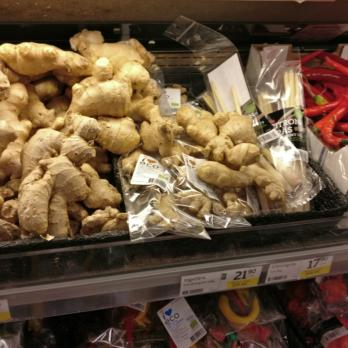


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image

# Ensure GPU usage if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define categories
categories = ['Packed', 'Unpacked']
category_to_idx = {category: idx for idx, category in enumerate(categories)}
idx_to_category = {idx: category for category, idx in category_to_idx.items()}

# Load the saved model
model = models.efficientnet_b0(pretrained=False)  # Load without pre-trained weights
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(categories))
model.load_state_dict(torch.load('/kaggle/working/efficientnet_b0_packed_unpacked1.pth', map_location=device))
model.to(device)
model.eval()

# Define the transformation for the input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def predict_image_class(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, predicted_label = torch.max(outputs, 1)

    predicted_label = predicted_label.item()
    predicted_category = idx_to_category[predicted_label]

    return predicted_label, predicted_category

# Example usage:
image_path = '/kaggle/input/grocery-store-dataset/GroceryStoreDataset/dataset/test/Vegetables/Ginger/Ginger_001.jpg'  # Replace with the path to your uploaded image
predicted_label, predicted_category = predict_image_class(image_path)

print("Predicted label:", predicted_label)
print("Predicted category:", predicted_category)

# Display the labelled classes and their actual names
print("\nLabelled classes and their actual names:")
for idx, category in idx_to_category.items():
    print(f"Label {idx}: {category}")

Used when we get error named CUDA out of memory 

In [ ]:
import torch,gc

torch.cuda.empty_cache()
gc.collect()